In [22]:
import numpy as n
import pandas as pd
from matplotlib import pyplot as plt
import math
from tqdm import tqdm

plt.style.use("dark_background")

In [39]:
df = pd.read_csv("X.csv")

In [40]:
fox = df[["frame",'id','image_index']][df["fox"]==1]
rabbit = df[["frame",'id','image_index']][df["fox"]==0]

In [41]:
fox_pf = []
rabbit_pf = []
for frame in tqdm(range(max(fox["frame"]))):
    fox_pf.append(fox[fox["frame"]==frame].count())
    rabbit_pf.append(rabbit[rabbit["frame"]==frame].count())

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 508.70it/s]


Text(0.5, 0, 'Frames')

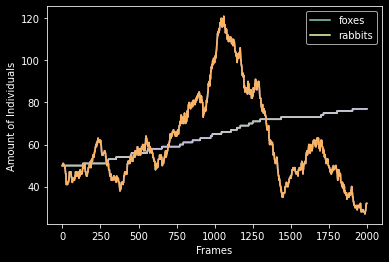

In [42]:
plt.plot(fox_pf)
plt.plot(rabbit_pf)
plt.legend(["foxes","rabbits"])
plt.ylabel("Amount of Individuals")
plt.xlabel("Frames")